In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pre_process_dataset import PreProcess
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras import regularizers

[nltk_data] Downloading package wordnet to /home/dip07/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/dip07/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-11-11 10:35:48.913646: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-11 10:35:48.948120: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-11 10:35:49.765550: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical r

In [2]:
df_train = pd.read_csv("data/medical_tc_train.csv")
df_test = pd.read_csv("data/medical_tc_test.csv")
df_train.loc[df_train['condition_label'] == 5, 'condition_label'] = 0.0
df_test.loc[df_test['condition_label'] == 5, 'condition_label'] = 0.0
print("The total number of training data is: %d" %(df_train.shape[0]))
print("The total number of testing data is: %d" %(df_test.shape[0]))

The total number of training data is: 11550
The total number of testing data is: 2888


In [3]:
df = pd.concat([df_train, df_test], ignore_index=True)
print(f"✅ Combined dataset size: {df.shape[0]} samples")

✅ Combined dataset size: 14438 samples


In [4]:
clean_df = PreProcess(df)
df = clean_df.preprocess_dataset()
df.head(1)

,condition_label,medical_abstract
0,0,tissue change around loose prosthesis canine m...


In [5]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['medical_abstract'])
y = df['condition_label']

In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_test.shape[0]}")
print(f"Test set size: {X_valid.shape[0]}")

Training set size: 10106
Validation set size: 2166
Test set size: 2166


In [7]:
# Scale features
scaler = StandardScaler(with_mean=False)
X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)
X_test = scaler.transform(X_test)

y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
y_test = to_categorical(y_test)

In [8]:
#hyper parameter tuning.

def create_model(learning_rate=0.001, dropout=0.3, hidden_units=32):
    model = Sequential([
        Dense(hidden_units, activation="relu", input_shape=(X_train.shape[1],)),
        Dropout(dropout),
        Dense(5, activation="softmax"),
    ])
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

model = KerasClassifier(
    model=create_model,
    epochs=40,
    batch_size=16,
    verbose=0,
    callbacks=[EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)]
)

param_dist = {
    "model__learning_rate": [0.01, 0.001, 0.0005],
    "model__dropout": [0.2, 0.3, 0.5],
    "model__hidden_units": [8, 16],
    "batch_size": [8, 16]
}

search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=5,    # only 5 trials to save CPU
    cv=3,
    verbose=1,
    n_jobs=-1
)

search.fit(X_valid, y_valid, validation_split=0.2)

# -------------------------------
# 6. Evaluate best model
# -------------------------------
print("\nBest hyperparameters:")
print(search.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


2025-11-11 10:36:03.991071: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-11 10:36:04.033517: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-11 10:36:04.036767: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-11 10:36:04.063211: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized t


Best hyperparameters:
{'model__learning_rate': 0.001, 'model__hidden_units': 16, 'model__dropout': 0.2, 'batch_size': 16}


In [14]:
input_dim = X_train.shape[1]

model = Sequential([
    Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001),
          input_shape=(input_dim,)),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

# Compile
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# -------------------------------
# 4. Early stopping
# -------------------------------
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
model.fit(X_train, y_train, epochs=10, batch_size=8, verbose=1)


Epoch 1/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.3879 - loss: 1.5722
Epoch 2/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.4562 - loss: 1.3780
Epoch 3/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.4905 - loss: 1.2678
Epoch 4/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5278 - loss: 1.2082
Epoch 5/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.5419 - loss: 1.1733
Epoch 6/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5604 - loss: 1.1613
Epoch 7/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.5740 - loss: 1.1554
Epoch 8/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5824 - loss: 1.1496
Epoch 9/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.5812 - loss: 1.1589
Epoch 10/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5934 - loss: 1.1487


In [15]:
loss, acc = model.evaluate(X_test, y_test)
print("Accuracy:", acc)

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5162 - loss: 1.3904
Accuracy: 0.5161588191986084


68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


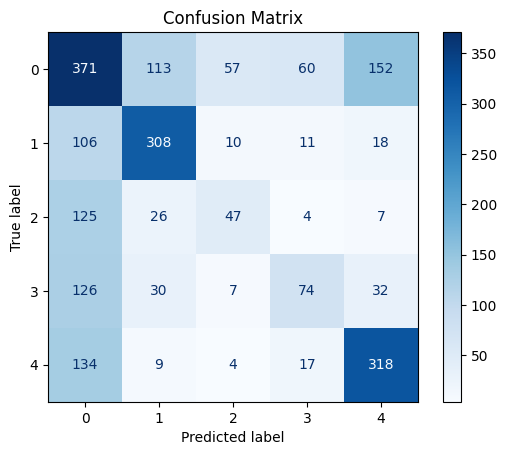


Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.49      0.46       753
           1       0.63      0.68      0.66       453
           2       0.38      0.22      0.28       209
           3       0.45      0.28      0.34       269
           4       0.60      0.66      0.63       482

    accuracy                           0.52      2166
   macro avg       0.50      0.47      0.47      2166
weighted avg       0.51      0.52      0.51      2166



In [16]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y.unique())
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))